# Assignment 3 by EE21S061 Arihant Jain

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn
import math
import torch.nn.functional as F


from util import onehot


In [5]:
MNIST_train = datasets.MNIST(root='./data', train = True , download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))
MNIST_test = datasets.MNIST(root='./data', train = False ,download=True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))]))

/home/arihant/notebooks/Deep_Learning/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


* Splitting the dataset into train test and validation as mentioned in the question.

In [6]:
train_set, val_set = torch.utils.data.random_split(MNIST_train, [50000, 10000])

In [7]:
train_data = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)

val_data = torch.utils.data.DataLoader(val_set, batch_size=100,shuffle=True)

test_data = torch.utils.data.DataLoader(MNIST_test, batch_size=100,shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
print("Dataset Length",len(MNIST_train))
print("Train Dataset Length",len(train_set))
print("Validation Dataset Length",len(val_set))
print("Test Dataset Length",len(MNIST_test))

Dataset Length 60000
Train Dataset Length 50000
Validation Dataset Length 10000
Test Dataset Length 10000


In [9]:
device = torch.device("cuda")
print(device)

cuda


In [7]:
!nvidia-smi

Sat Oct 15 00:52:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:09:00.0 Off |                  N/A |
|  0%   41C    P8    35W / 350W |   3048MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST Classification using RNN

* In this section we will be trying to learn to classify digit using RNN model.
* As mentioned in the Assignment the image is feed into the network as a sequence of vector each of length 28 which is the input dimension and goes through the network and comes out as a 10 class probability distribution which is output dimension for this network


## Vanilla RNN

In [8]:
class RNN(nn.Module):
    
    def __init__(self,input_dim,hidden_dim,output_dim,num_lay, bi = False):
        
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_lay
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_lay,bidirectional=bi)  
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        
        X = X.permute(1, 0, 2)
        hiddenlayer=torch.zeros(num_layers,X.size(1),hidden_dim,device=device)
        out,hiddenlayer = self.rnn(X,hiddenlayer.detach())  
        out = self.layer2(out[-1,:,:])
        return out.reshape(100,10)

class BIRNN(nn.Module):

    def __init__(self,input_dim,hidden_dim,output_dim,num_lay, bi = False):

        super(BIRNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_lay

        self.rnn = nn.RNN(input_dim, hidden_dim, num_lay,bidirectional=bi)  
        self.layer2 = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, X):

        X = X.permute(1, 0, 2)
        hiddenlayer=torch.zeros(2*num_layers,X.size(1),hidden_dim,device=device)
        out,hiddenlayer = self.rnn(X,hiddenlayer.detach())  
        finp,binp=hiddenlayer[0],hiddenlayer[1]
        inp=torch.cat((finp,binp),dim=-1)
        out = self.layer2(inp)
        return out

def plot_metrics(res):
    fig , (train,valida,acc) =  plt.subplots(3,1,figsize=(15, 15))
    train.plot(res["train_loss"])
    train.title.set_text("Training loss per iteration last epoch")


    valida.plot(res["val_loss"])
    valida.title.set_text("Validation loss per epoch")

    acc.plot(res["val_acc"])
    acc.title.set_text("Validation Accuracy per epoch")


In [17]:
classes = 10
epochs = 10
batch_size = 100
seq_len = 28
input_dim = 28
hidden_dim = 128
num_layers = 1
output_dim = 10
learning_rate = 0.002
epochs = 10
regul=0.01
loss_fn= nn.CrossEntropyLoss()

In [10]:
def train_model(model,epoch,train_loader,val_loader,regularization = 0):
    metrics = {"train_loss": [],"val_loss": [],"val_acc": []}
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epoch):
        for i, (images, labels) in enumerate(train_loader):
            
            img = images.to(device)
            target = labels.to(device)

            img = img.reshape(-1, 28, 28) 
            outputs = model(img)
            if (regularization != 0):
                loss = loss_fn(outputs, target) + regularization*torch.norm(model.layer2.weight)
            else:
                loss = loss_fn(outputs, target)
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        iteration=0
        tempvalloss=0
        correctval=0    
        for images, labels in val_loader:
            img = images.to(device)
            target = labels.to(device)

            img = img.reshape(-1, 28, 28) 
            outputs = model(img)
            loss = loss_fn(outputs, target)
            _, predicted = torch.max(outputs.data, 1)
            correctval += (predicted == target).sum().item()
            iteration+=1
            tempvalloss+=loss.item()

        metrics["val_loss"].append(tempvalloss/iteration)
        metrics["val_acc"].append(correctval/100)
        print("Epoch :" , epoch +1 , "val_loss :" ,round(metrics["val_loss"][-1],3), "val_acc :" ,metrics["val_acc"][-1])
    return model,metrics
    

In [11]:
def test_model(model,test_loader):
    metrics = {"test_acc": []}
    model.to(device)
    
    iteration=0
    correctval=0    
    for images, labels in test_loader:
        img = images.to(device)
        target = labels.to(device)

        img = img.reshape(-1, 28, 28) 
        outputs = model(img)
        loss = loss_fn(outputs, target)
        _, predicted = torch.max(outputs.data, 1)
        correctval += (predicted == target).sum().item()
        iteration+=1

    metrics["test_acc"].append(correctval/100)
    print("Test Accuracy :",metrics["test_acc"][-1])
    return metrics
    

In [12]:
model,res = train_model(RNN(input_dim,hidden_dim,output_dim,num_layers),10,train_data,val_data)

Epoch : 1 val_loss : 0.398 val_acc : 88.0
Epoch : 2 val_loss : 0.4 val_acc : 87.8
Epoch : 3 val_loss : 0.241 val_acc : 93.09
Epoch : 4 val_loss : 0.23 val_acc : 93.91
Epoch : 5 val_loss : 0.178 val_acc : 94.93
Epoch : 6 val_loss : 0.21 val_acc : 94.43
Epoch : 7 val_loss : 0.235 val_acc : 93.72
Epoch : 8 val_loss : 0.235 val_acc : 93.85
Epoch : 9 val_loss : 0.16 val_acc : 95.59
Epoch : 10 val_loss : 0.16 val_acc : 95.83


### Vanilla RNN without Regularization

In [13]:
test_model(model,test_data)

Test Accuracy : 95.5


{'test_acc': [95.5]}

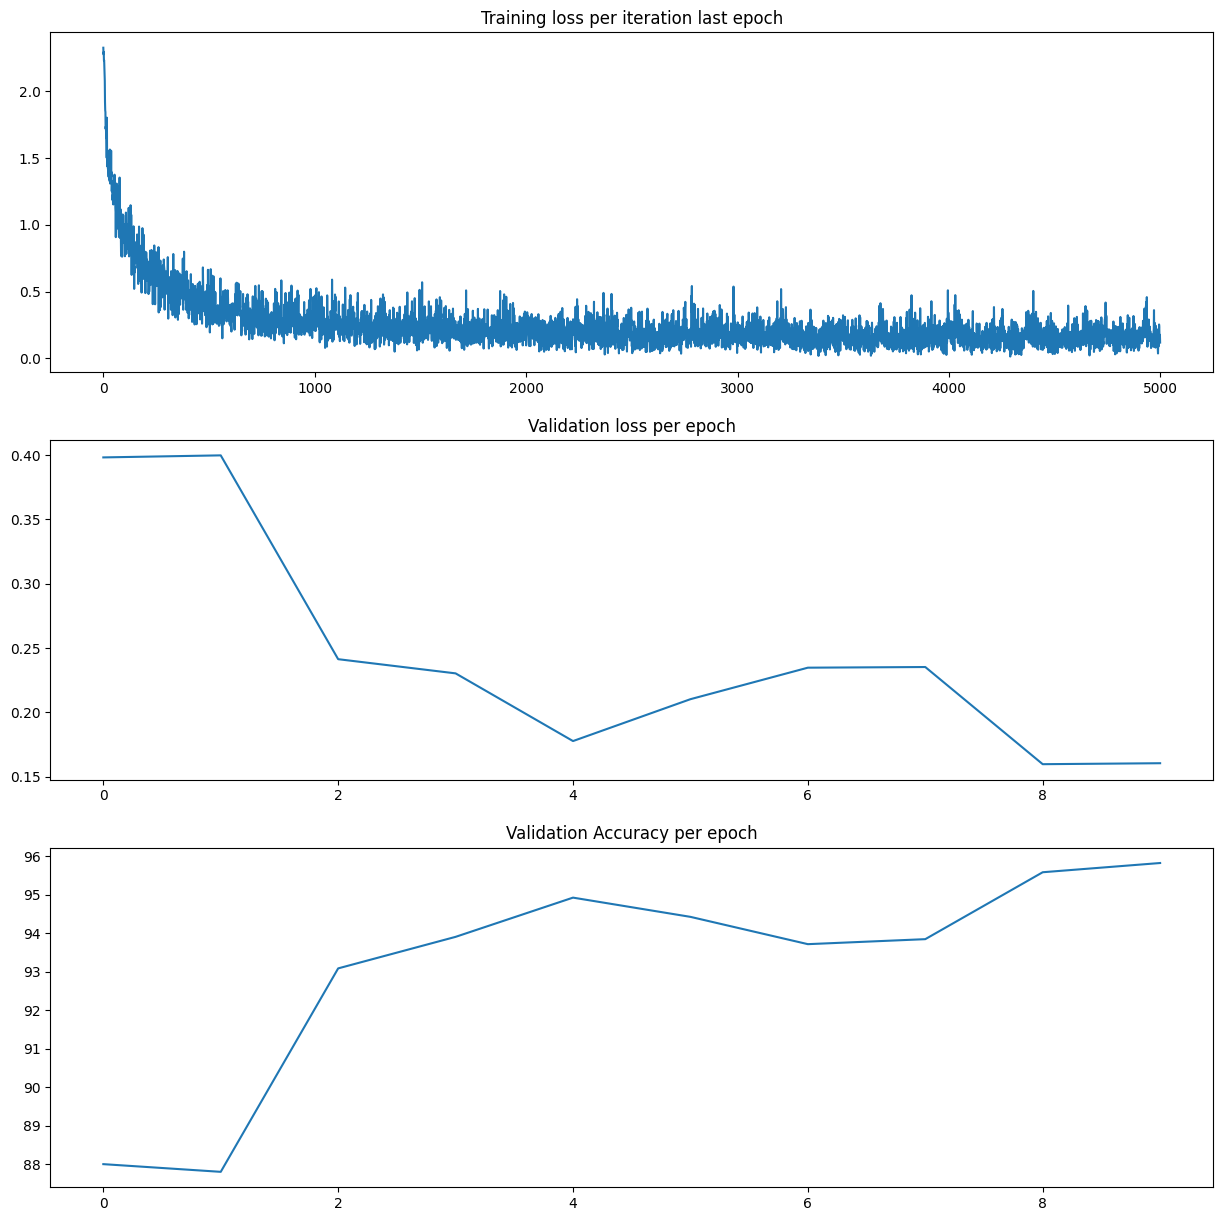

In [14]:
plot_metrics(res)

In [15]:
model_reg,res_reg = train_model(RNN(input_dim,hidden_dim,output_dim,num_layers),10,train_data,val_data,regularization = regul)

Epoch : 1 val_loss : 0.389 val_acc : 87.8
Epoch : 2 val_loss : 0.265 val_acc : 92.68
Epoch : 3 val_loss : 0.239 val_acc : 93.64
Epoch : 4 val_loss : 0.243 val_acc : 93.23
Epoch : 5 val_loss : 0.229 val_acc : 93.56
Epoch : 6 val_loss : 0.205 val_acc : 94.53
Epoch : 7 val_loss : 0.174 val_acc : 95.3
Epoch : 8 val_loss : 0.196 val_acc : 94.88
Epoch : 9 val_loss : 0.186 val_acc : 95.01
Epoch : 10 val_loss : 0.178 val_acc : 95.27


### Vanilla RNN with Regularization

In [16]:
test_model(model_reg,test_data)

Test Accuracy : 94.86


{'test_acc': [94.86]}

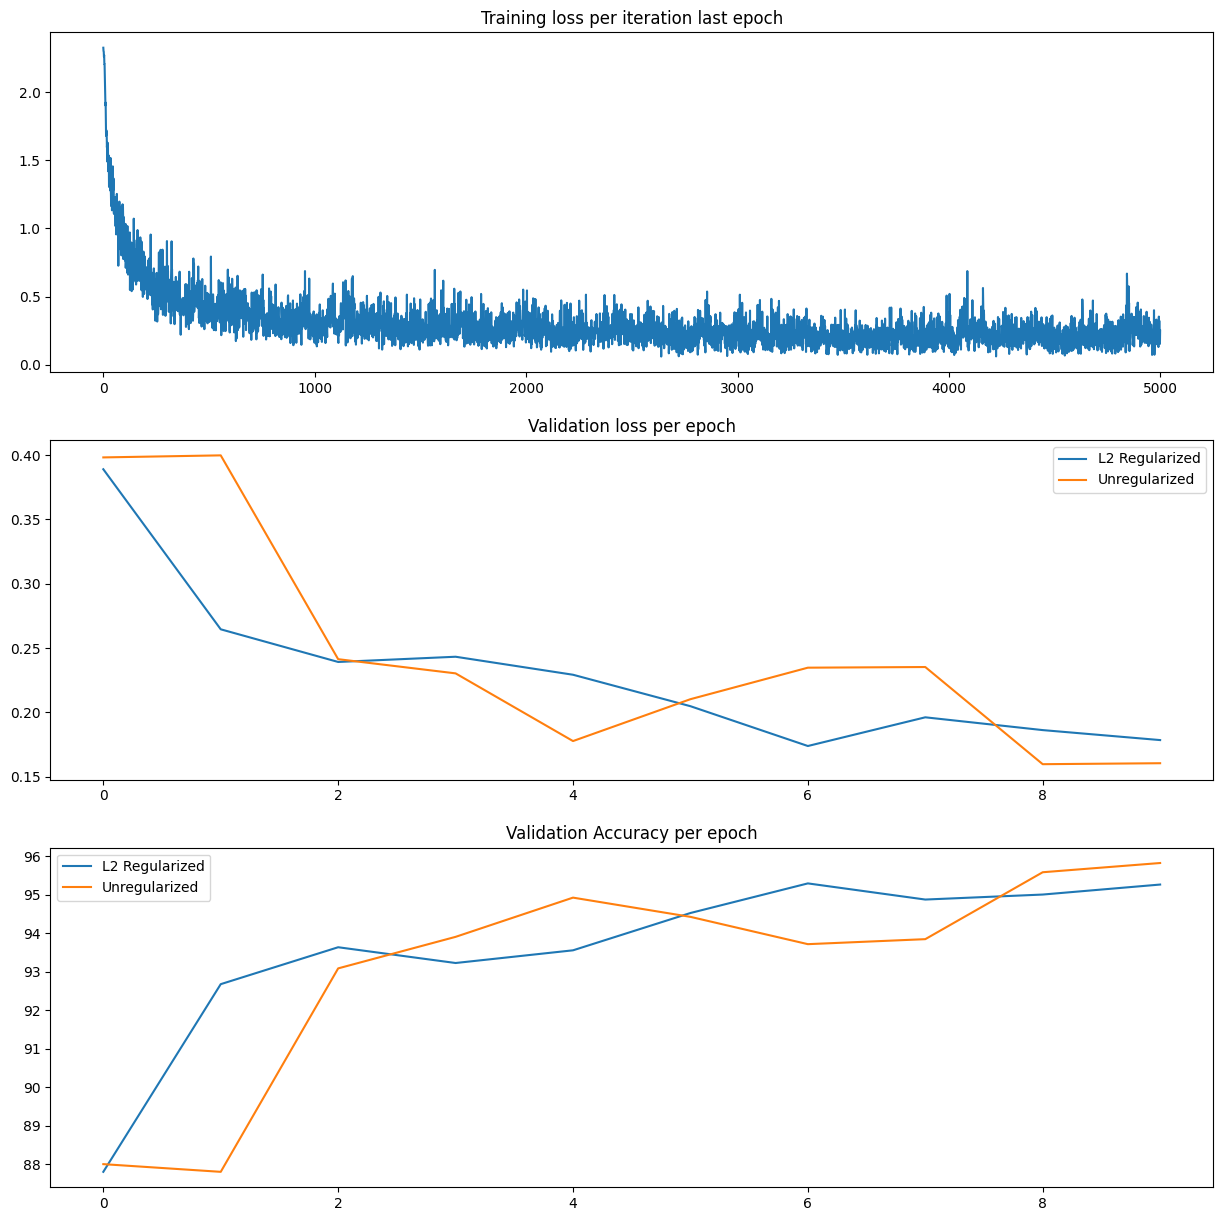

In [17]:
import matplotlib.pyplot as plt
fig , (train,valida,acc) =  plt.subplots(3,1,figsize=(15, 15))

train.plot(res_reg["train_loss"])
train.title.set_text("Training loss per iteration last epoch")

valida.plot(res_reg["val_loss"],label = "L2 Regularized")
valida.plot(res["val_loss"],label = "Unregularized")
valida.legend()
valida.title.set_text("Validation loss per epoch")

acc.plot(res_reg["val_acc"],label = "L2 Regularized")
acc.plot(res["val_acc"],label = "Unregularized")
acc.legend()
acc.title.set_text("Validation Accuracy per epoch")

* In this we can see that Regularized Vanilla RNN have a better score in validation accuracy as well as test accuracy this is due to the reduction in capacity which makes the model more general and hence score better on validation and test data

## LSTM

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bi = False):
        
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,bidirectional=bi)  
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        
        hiddenlayer = torch.zeros(self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        cellstatelayer = torch.zeros(self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        X = X.permute(1, 0, 2)
        
        out, (hn,cn) = self.lstm(X, (hiddenlayer.detach(),cellstatelayer.detach()))
        out = self.fc(out[-1])
        return out.reshape(100,10)
    
class BILSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bi = False):
        
        super(BILSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,bidirectional=bi)  
        self.fc = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, X):
        
        hiddenlayer = torch.zeros(2*self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        cellstatelayer = torch.zeros(2*self.num_layers, X.size(0), self.hidden_dim).to("cuda")
        X = X.permute(1, 0, 2)
        
        out, (hn,cn) = self.lstm(X, (hiddenlayer.detach(),cellstatelayer.detach()))
        out = self.fc(out[-1])
        return out.reshape(100,10)


In [19]:
model_lstm,res_lstm = train_model(LSTM(input_dim,hidden_dim,output_dim,num_layers),10,train_data,val_data)

Epoch : 1 val_loss : 0.115 val_acc : 96.61
Epoch : 2 val_loss : 0.087 val_acc : 97.44
Epoch : 3 val_loss : 0.101 val_acc : 96.99
Epoch : 4 val_loss : 0.062 val_acc : 98.18
Epoch : 5 val_loss : 0.054 val_acc : 98.46
Epoch : 6 val_loss : 0.051 val_acc : 98.5
Epoch : 7 val_loss : 0.052 val_acc : 98.5
Epoch : 8 val_loss : 0.059 val_acc : 98.35
Epoch : 9 val_loss : 0.052 val_acc : 98.53
Epoch : 10 val_loss : 0.056 val_acc : 98.57


In [20]:
test_model(model_lstm,test_data)

Test Accuracy : 98.49


{'test_acc': [98.49]}

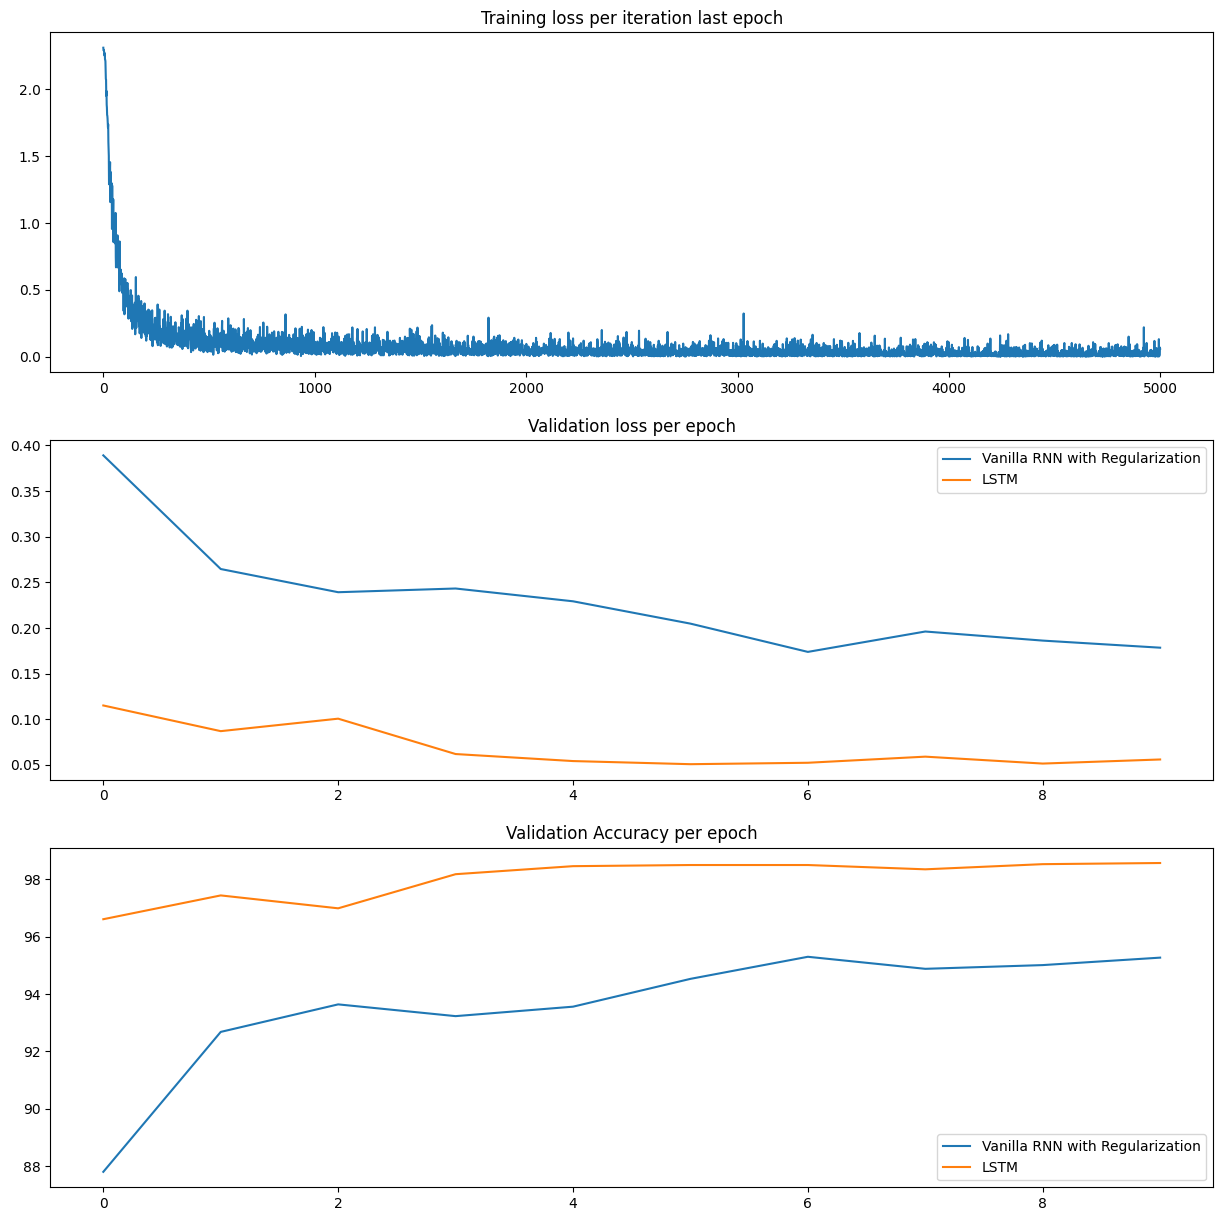

In [21]:
import matplotlib.pyplot as plt
fig , (train,valida,acc) =  plt.subplots(3,1,figsize=(15, 15))

train.plot(res_lstm["train_loss"])
train.title.set_text("Training loss per iteration last epoch")

valida.plot(res_reg["val_loss"],label = "Vanilla RNN with Regularization")
valida.plot(res_lstm["val_loss"],label = "LSTM")
valida.legend()
valida.title.set_text("Validation loss per epoch")

acc.plot(res_reg["val_acc"],label = "Vanilla RNN with Regularization")
acc.plot(res_lstm["val_acc"],label = "LSTM")
acc.legend()
acc.title.set_text("Validation Accuracy per epoch")

* Comparing against RNN we can see clear difference between the 2 models.
* LSTM starts from a higher score and keeps its lead in the accuracy since the very first epoch this is because of selecting only important information to be passed to the next states in RNN.

## Bi-Directional RNN

In [22]:
model_bi,res_bi = train_model(BIRNN(input_dim,hidden_dim,output_dim,num_layers, bi=True),10,train_data,val_data)

Epoch : 1 val_loss : 0.24 val_acc : 93.05
Epoch : 2 val_loss : 0.199 val_acc : 94.39
Epoch : 3 val_loss : 0.168 val_acc : 95.19
Epoch : 4 val_loss : 0.138 val_acc : 95.98
Epoch : 5 val_loss : 0.138 val_acc : 96.04
Epoch : 6 val_loss : 0.128 val_acc : 96.27
Epoch : 7 val_loss : 0.13 val_acc : 96.36
Epoch : 8 val_loss : 0.117 val_acc : 96.58
Epoch : 9 val_loss : 0.118 val_acc : 96.68
Epoch : 10 val_loss : 0.139 val_acc : 95.93


In [23]:
test_model(model_bi,test_data)

Test Accuracy : 96.08


{'test_acc': [96.08]}

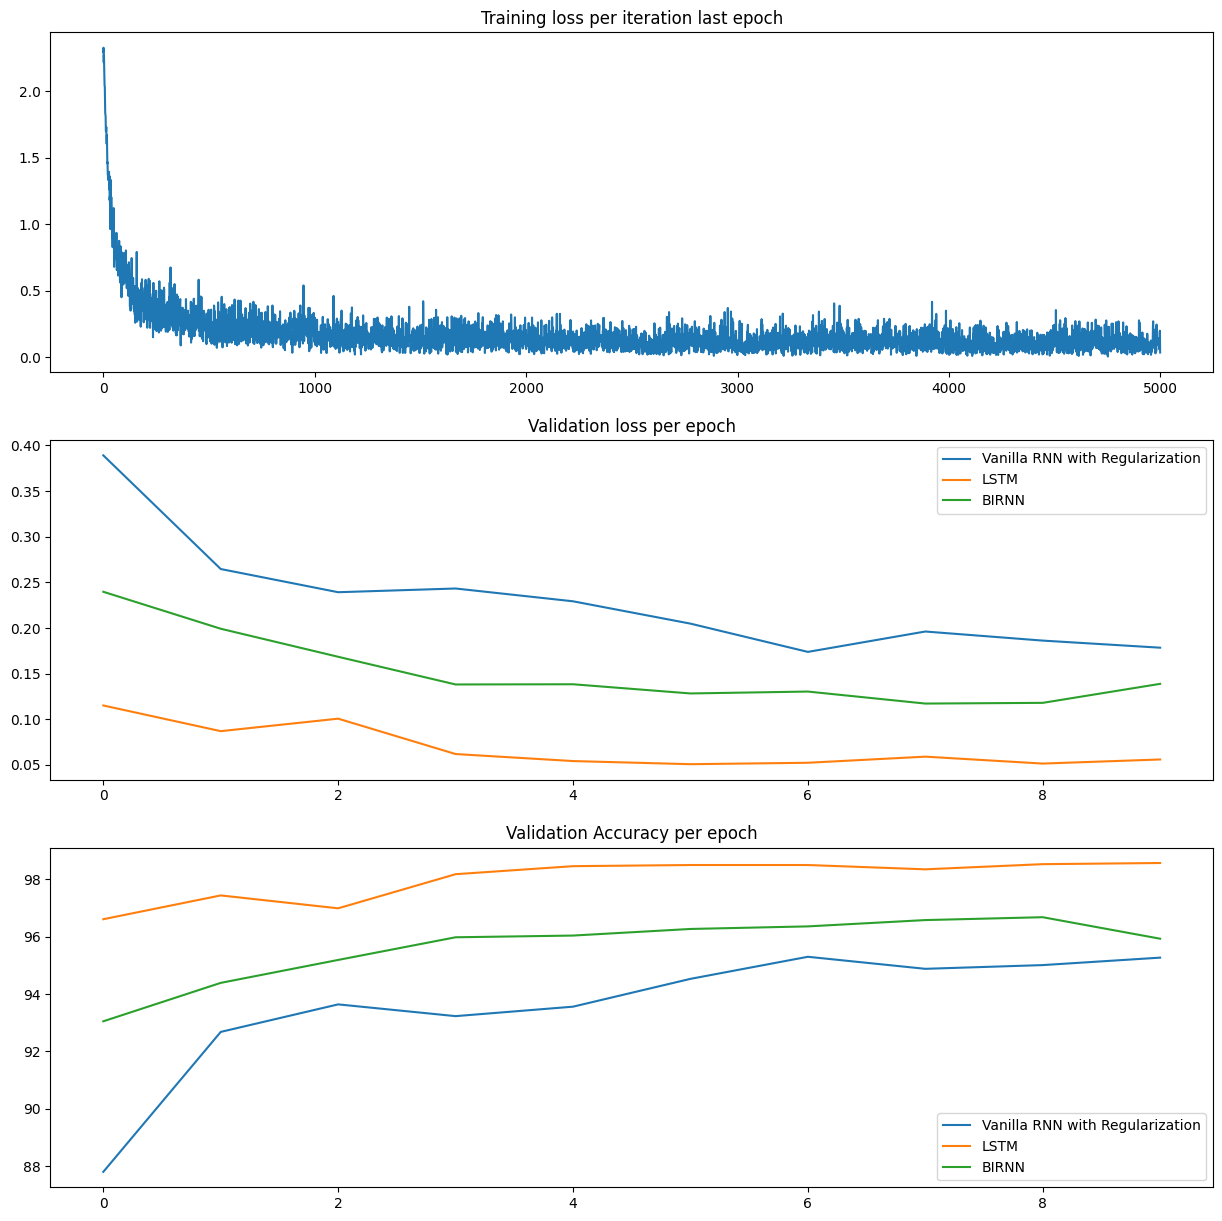

In [24]:
import matplotlib.pyplot as plt
fig , (train,valida,acc) =  plt.subplots(3,1,figsize=(15, 15))

train.plot(res_bi["train_loss"])
train.title.set_text("Training loss per iteration last epoch")

valida.plot(res_reg["val_loss"],label = "Vanilla RNN with Regularization")
valida.plot(res_lstm["val_loss"],label = "LSTM")
valida.plot(res_bi["val_loss"],label = "BIRNN")
valida.legend()
valida.title.set_text("Validation loss per epoch")

acc.plot(res_reg["val_acc"],label = "Vanilla RNN with Regularization")
acc.plot(res_lstm["val_acc"],label = "LSTM")
acc.plot(res_bi["val_acc"],label = "BIRNN")
acc.legend()
acc.title.set_text("Validation Accuracy per epoch")

* Even with Bi-directional option being enabled lead by LSTM is still there bidirection RNN is better then Vanilla RNN but lacks the benefits of LSTM which account for vanishing gradient and also loss of context as the model gets bigger in sequence.

## Bi-Directional LSTM

In [25]:
model_bilstm,res_bilstm = train_model(BILSTM(input_dim,hidden_dim,output_dim,num_layers,bi=True),10,train_data,val_data)

Epoch : 1 val_loss : 0.128 val_acc : 96.24
Epoch : 2 val_loss : 0.109 val_acc : 96.47
Epoch : 3 val_loss : 0.087 val_acc : 97.33
Epoch : 4 val_loss : 0.065 val_acc : 97.87
Epoch : 5 val_loss : 0.046 val_acc : 98.6
Epoch : 6 val_loss : 0.064 val_acc : 98.11
Epoch : 7 val_loss : 0.068 val_acc : 98.16
Epoch : 8 val_loss : 0.053 val_acc : 98.41
Epoch : 9 val_loss : 0.046 val_acc : 98.69
Epoch : 10 val_loss : 0.049 val_acc : 98.67


In [26]:
test_model(model_bilstm,test_data)

Test Accuracy : 98.82


{'test_acc': [98.82]}

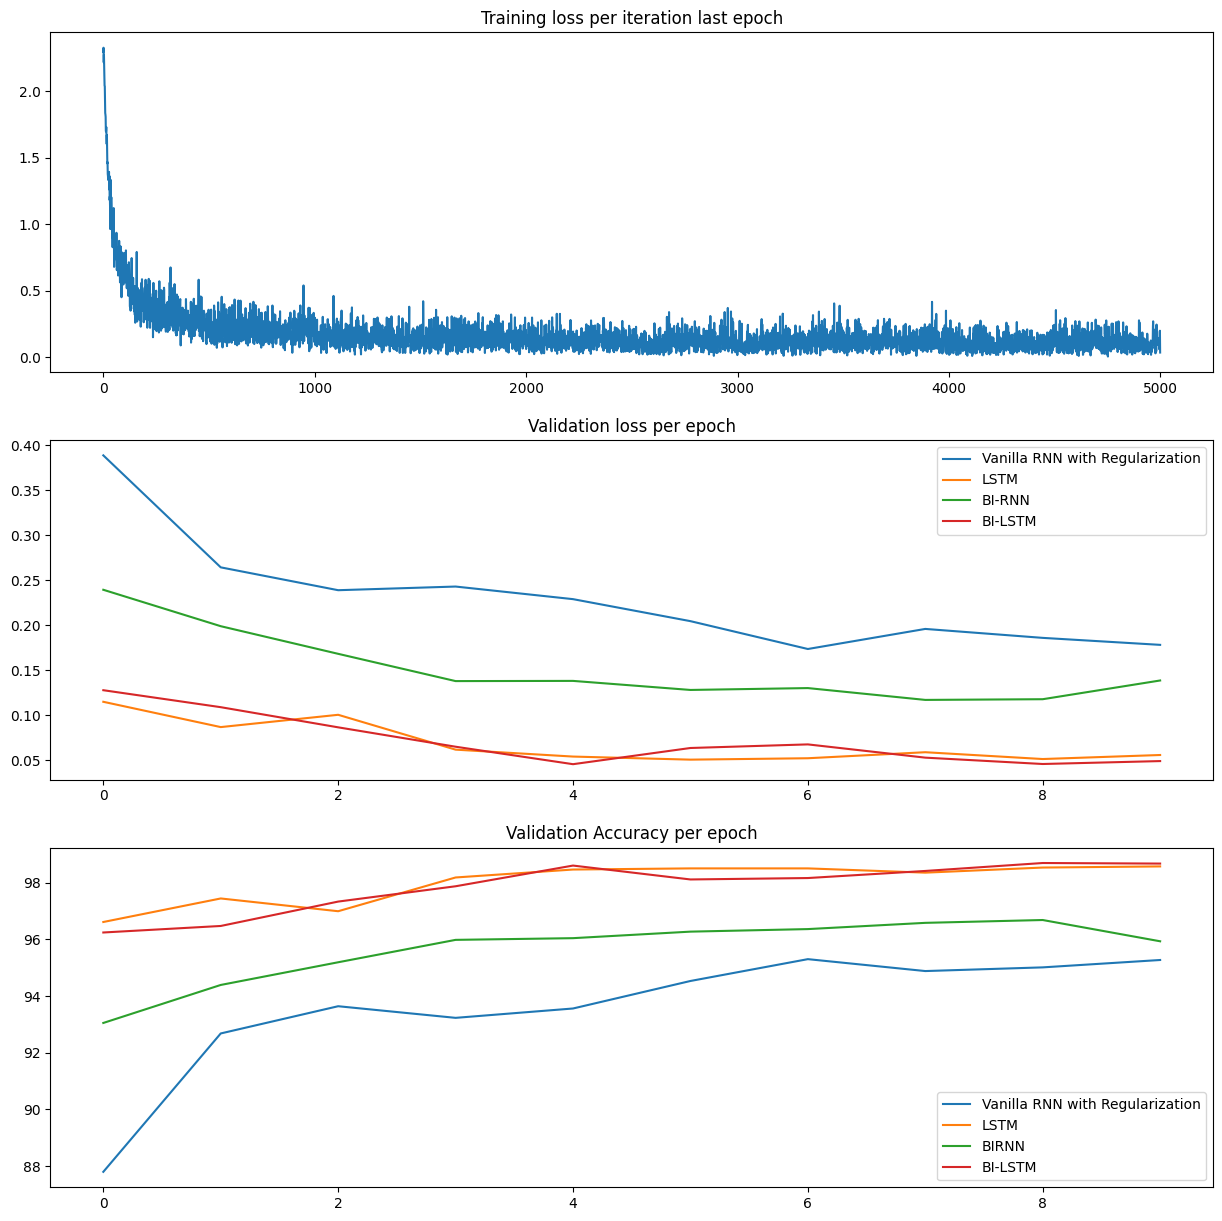

In [27]:
import matplotlib.pyplot as plt
fig , (train,valida,acc) =  plt.subplots(3,1,figsize=(15, 15))

train.plot(res_bi["train_loss"])
train.title.set_text("Training loss per iteration last epoch")

valida.plot(res_reg["val_loss"],label = "Vanilla RNN with Regularization")
valida.plot(res_lstm["val_loss"],label = "LSTM")
valida.plot(res_bi["val_loss"],label = "BI-RNN")
valida.plot(res_bilstm["val_loss"],label = "BI-LSTM")
valida.legend()
valida.title.set_text("Validation loss per epoch")

acc.plot(res_reg["val_acc"],label = "Vanilla RNN with Regularization")
acc.plot(res_lstm["val_acc"],label = "LSTM")
acc.plot(res_bi["val_acc"],label = "BIRNN")
acc.plot(res_bilstm["val_acc"],label = "BI-LSTM")
acc.legend()
acc.title.set_text("Validation Accuracy per epoch")

* Doing Bidirection LSTM shows how close we are the best model we can get the accuracy for Vanilla LSTM is already touching 98.2 which is really really good so trying to improve on that is already a hard task. Bi-directional LSTM performs as good as LSTM or slightly better.

Images:


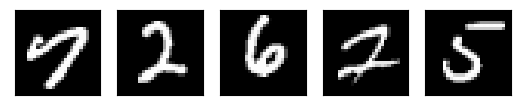

Prediction: [7. 2. 6. 2. 5.]
Real label: [7. 2. 6. 2. 5.]


In [48]:
k=1
print('Images:')
a=(5*np.abs(np.random.rand(5))).astype(int)
predict=np.zeros(5)
actual=np.zeros(5)
fig,ax = plt.subplots()
for i in range(5):
    for images,labels in test_data:
        images = images.reshape(-1, 28, 28) 
        images = images.to("cuda")
        ax=plt.subplot(1,5,k)
        ax.set_xticks([])
        ax.set_yticks([])
        im=ax.imshow(images[a[i]].cpu().reshape(28,28),cmap='gray')
        _,predicted=torch.max(model_bilstm(images)[a[i]],0)
        predict[i]=predicted.item()
        actual[i]=labels[a[i]]
        break
    k+=1
plt.show()
print('Prediction:',predict)
print('Real label:',actual)

## Verifying model on self handwritten digits

In [29]:
%cd handwritten_digit
!dir

/home/arihant/notebooks/EE5179/Assignments/Assignment 3/handwritten_digit
0.png  1.png  2.png  3.png  4.png  5.png  6.png  7.png	8.png  9.png


In [30]:
import os
name = os.listdir()

In [46]:
from PIL import Image, ImageOps
def binary_image(im):
    image = torch.zeros(im.size[0],im.size[0]).to("cuda")
    for i in range(im.size[0]):
        for j in range(im.size[1]):
            if (im.getpixel((i,j)) >109):
                image[j,i] = 1 
            else:
                image[j,i] = 0
    return image.cpu()

Images:


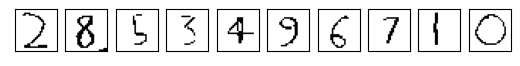

Prediction RNN: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction BIRNN: [8. 7. 6. 7. 7. 7. 9. 7. 6. 8.]
Prediction LSTM: [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
Prediction BILSTM: [8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
Real label: [2. 8. 5. 3. 4. 9. 6. 7. 1. 0.]


In [47]:
k=0
print('Images:')
predict_rnn=np.zeros(10)
predict_birnn=np.zeros(10)
predict_lstm=np.zeros(10)
predict_bilstm=np.zeros(10)
actual=np.zeros(10)
fig,ax = plt.subplots()
for j in name:
    im = Image.open(j).resize((28,28))
    im = ImageOps.grayscale(im)
    image = binary_image(im)
    images = image.repeat(100,1,1)
    images = images.to("cuda")
    ax=plt.subplot(1,10,k+1)
    ax.set_xticks([])
    ax.set_yticks([])
    im=ax.imshow(images[0].cpu().reshape(28,28),cmap='gray')
    _,predicted=torch.max(model_reg(images)[0],0)
    predict_rnn[k]=predicted.item()
    _,predicted=torch.max(model_bi(images)[0],0)
    predict_birnn[k]=predicted.item()
    _,predicted=torch.max(model_lstm(images)[0],0)
    predict_lstm[k]=predicted.item()
    _,predicted=torch.max(model_bilstm(images)[0],0)
    predict_bilstm[k]=predicted.item()
    actual[k]=int(j[0][0])
    k+=1
plt.show()
print('Prediction RNN:',predict_rnn)
print('Prediction BIRNN:',predict_birnn)
print('Prediction LSTM:',predict_lstm)
print('Prediction BILSTM:',predict_bilstm)
print('Real label:',actual)

* The None of the model is working on my own handwritten digit it might be cause the digit are too skinny unlike the one provided in MNIST this shows that model with accuracy on a Dataset might fail in real life scenarios.

In [49]:
!dir

0.png  1.png  2.png  3.png  4.png  5.png  6.png  7.png	8.png  9.png


In [50]:
%cd ..

/home/arihant/notebooks/EE5179/Assignments/Assignment 3


# Predicting number at given index in a sequence

In [29]:
def rannumbcreator(L):
    ranlist=np.random.randint(0,10,L)
    return ranlist

def getonehot(X):
    x = np.zeros((len(X), 10))
    x[np.arange(len(X)), X] = 1
    return x 

In [40]:
class LSTM_sequence(nn.Module):
    def __init__(self,hidsize):
        super(LSTM_sequence, self).__init__()
        self.hidsize=hidsize
        self.lstm = nn.LSTM(10,hidsize)
        self.layer2 = nn.Linear(hidsize, 10)

    def forward(self, X):
        hiddenstate=torch.zeros(1,X.size(0),self.hidsize)
        cellstate=torch.zeros(1,X.size(0),self.hidsize)
        X=X.permute(1,0,2)
        out,(hs,cs) = self.lstm(X,(hiddenstate,cellstate)) 
        out = self.layer2(out[-1])
        return out.reshape(1,10)

learning_rate = 0.003
epochs = 10


* Writting the custom code to generate sequence with length which can vary between 3 to 10

In [39]:
trainranlist=[]
valranlist=[]
testranlist=[]
for i in range(100):
    for j in range(3,11):
        trainranlist.append(rannumbcreator(j))
    L=np.random.randint(3,11)
    valranlist.append(rannumbcreator(L))
    L=np.random.randint(3,11)
    testranlist.append(rannumbcreator(L))

In [87]:
def train_model_sequence(hidstatesize,epochs = 20):
    
    metrics = {"train_loss": [],"val_acc": []}
    
    iteration=0
    tempvalloss=0
    correctval=0  

    model=LSTM_sequence(hidstatesize)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        
        for i in range(len(trainranlist)):  
            
            ranlist=torch.zeros((1,len(trainranlist[i]),10))
            ranlist[0]=torch.from_numpy(getonehot(trainranlist[i]))

            output=model(ranlist.float())
            _,predicted=torch.max(output.data,1)

            label=torch.tensor([trainranlist[i][K]],dtype=torch.long)
            loss = loss_fn(output, label.long())
            metrics["train_loss"].append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        iteration=0
        tempvalloss=0
        correctval=0 
            
        for i in range(len(valranlist)):  
            
            ranlist=torch.zeros((1,len(valranlist[i]),10))
            ranlist[0]=torch.from_numpy(getonehot(valranlist[i]))

            output=model(ranlist.float())
            _,predicted=torch.max(output.data,1)

            label=torch.tensor([valranlist[i][K]],dtype=torch.long)
            _, predicted = torch.max(output.data, 1)
            correctval += (predicted == label).sum().item()
            iteration+=1
        metrics["val_acc"].append(correctval/len(valranlist)*100)
            
    return model,metrics

def test_model_sequence(model):
    
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i in range(len(testranlist)):
            ranlist=torch.zeros((1,len(testranlist[i]),10))
            ranlist[0]=torch.from_numpy(getonehot(testranlist[i]))
            output=model(ranlist.float())
            label=torch.tensor([testranlist[i][K]],dtype=torch.long)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()

        print('Test Accuracy of the model on the 100 test samples: {} %'.format((correct / len(testranlist)) * 100))


In [88]:
model_seq_2,metrics_2 = train_model_sequence(2)
model_seq_5,metrics_5 = train_model_sequence(5)
model_seq_10,metrics_10 = train_model_sequence(10)

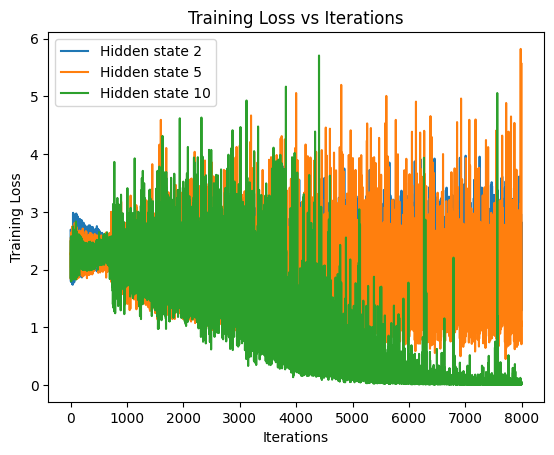

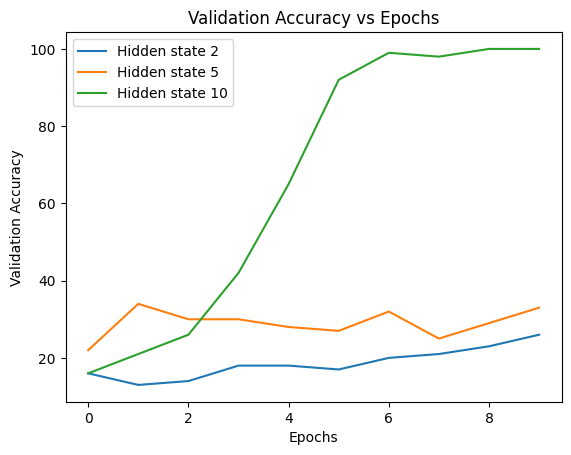

In [89]:
plt.figure(1)

xtrainloss=np.arange(len(metrics_2["train_loss"]))

plt.plot(xtrainloss,metrics_2["train_loss"],label="Hidden state 2")
plt.plot(xtrainloss,metrics_5["train_loss"],label="Hidden state 5")
plt.plot(xtrainloss,metrics_10["train_loss"],label="Hidden state 10")
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Iterations')
plt.legend()

plt.figure(2)

xvalloss=np.arange(len(metrics_2["val_acc"]))

plt.plot(xvalloss,metrics_2["val_acc"],label="Hidden state 2")

plt.plot(xvalloss,metrics_5["val_acc"],label="Hidden state 5")

plt.plot(xvalloss,metrics_10["val_acc"],label="Hidden state 10")

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Epochs')
plt.legend()
plt.show()

* We can see as we increase the hidden state the accuracy increases this is due to the capacity increase of the model which allows the model to learn more about the problem.

In [90]:
test_model_sequence(model_seq_2)

Test Accuracy of the model on the 100 test samples: 20.0 %


In [91]:
test_model_sequence(model_seq_5)

Test Accuracy of the model on the 100 test samples: 28.999999999999996 %


In [92]:
test_model_sequence(model_seq_10)

Test Accuracy of the model on the 100 test samples: 100.0 %


* Using the best performing model which is with 10 hidden state at 100% accuracy lets generate some test data and visualize how the output looks.

In [94]:
for i in range(3,11):
    print("For Length",i)
    for j in range(3):
        a=rannumbcreator(i)
        hotranlist=torch.zeros((1,len(a),10))
        hotranlist[0]=torch.from_numpy(getonehot(a))
        output=model_seq_10(hotranlist.float())
        label=torch.tensor([a[K]],dtype=torch.long)
        _, predicted = torch.max(output.data, 1)
        print("Array:",a,"Prediction at position 2:",predicted.item())

For Length 3
Array: [3 7 2] Prediction at position 2: 7
Array: [6 7 7] Prediction at position 2: 7
Array: [1 3 6] Prediction at position 2: 3
For Length 4
Array: [2 4 8 0] Prediction at position 2: 4
Array: [4 9 1 9] Prediction at position 2: 9
Array: [2 2 6 3] Prediction at position 2: 2
For Length 5
Array: [4 1 7 5 7] Prediction at position 2: 1
Array: [6 5 7 2 2] Prediction at position 2: 5
Array: [3 6 2 7 0] Prediction at position 2: 6
For Length 6
Array: [0 1 8 9 0 0] Prediction at position 2: 1
Array: [1 0 3 3 2 0] Prediction at position 2: 0
Array: [8 2 4 7 5 6] Prediction at position 2: 2
For Length 7
Array: [2 2 1 4 7 9 7] Prediction at position 2: 2
Array: [8 7 1 1 5 3 9] Prediction at position 2: 7
Array: [9 0 4 3 8 4 4] Prediction at position 2: 0
For Length 8
Array: [3 7 6 7 6 1 2 8] Prediction at position 2: 7
Array: [4 3 0 6 2 1 9 5] Prediction at position 2: 3
Array: [2 7 0 8 5 7 8 5] Prediction at position 2: 7
For Length 9
Array: [4 9 4 6 3 4 8 5 6] Prediction at posi

* We can see that all the prediction by the model are correct